# Loteca

In [1]:
import keras
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

Using TensorFlow backend.


### Ler arquivo

In [2]:
df = np.load('arquivo.npy')

In [3]:
# Define o ganhador H = casa, A = Vizitante, D = empate
for i in range(len(df)):
    df[i,8] = 'H' if (int(df[i,2]) - int(df[i,6])) > 0 else 'A' if (int(df[i,2]) - int(df[i,6])) < 0 else 'D'

In [4]:
# Cria um data frame para receber os valores
df_ = pd.DataFrame(df,columns=['Concurso','Jogo','HG','Home','S','Away','AG','Dia','Res'])

In [5]:
# Transforma as colunas de gols em inteiros
df_ = df_.astype({"HG": int, "AG": int})

In [6]:
df_.head()

,Concurso,Jogo,HG,Home,S,Away,AG,Dia,Res
0,Concurso 1 (18/02/2002),1,2,FLAMENGO/RJ,,S. PAULO/SP,4,Domingo,A
1,Concurso 1 (18/02/2002),2,3,VASCO/RJ,,AMERICANO/RJ,0,Domingo,H
2,Concurso 1 (18/02/2002),3,2,SANTOS/SP,,SÃO CAETANO/SP,1,Domingo,H
3,Concurso 1 (18/02/2002),4,1,P. DESPORTOS/SP,,CORINTHIANS/SP,4,Domingo,A
4,Concurso 1 (18/02/2002),5,7,CRUZEIRO/MG,,AMÉRICA/MG,0,Sábado,H


### Frequencia de vitórias em casa (H), empates (D) e visitantes (A)

<BarContainer object of 3 artists>

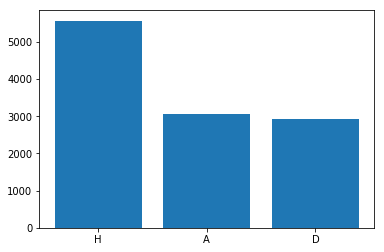

In [7]:
plt.bar(df_['Res'].value_counts().keys(),df_['Res'].value_counts())

### Média de gols dos últimos jogos

In [151]:
# Calcula a soma de gols feitos das ultimas n (window) partidas
def get_rolling_mean(dataFrame, equip, pos, window, HG_AG):   
    HA = 'Home' if HG_AG == 'HG' else 'Away' if HG_AG == 'AG' else ''
    s = dataFrame[-pos-window:-window][dataFrame[HA] == equip][HG_AG].mean()
    return s if not(np.isnan(s)) else 0

# Calcula a soma de gols recebidos das ultimas n (window) partidas
def get_rolling_received(dataFrame, equip, pos, window, HG_AG):   
    HA = 'Home' if HG_AG == 'HG' else 'Away' if HG_AG == 'AG' else ''
    HG_AG_ = 'HG' if HG_AG == 'AG' else 'AG' if HG_AG == 'HG' else ''
    s = dataFrame[-pos-window:-window][dataFrame[HA] == equip][HG_AG_].mean()
    return s if not(np.isnan(s)) else 0

    

### Nomes dos times

In [9]:
# Cria uma lista de nomes dos times
vocab = np.unique(np.concatenate((np.array(df_['Home'].unique()), np.array(df_['Away'].unique()))))

### Nomes dos times

In [8]:
vocab = np.unique(np.concatenate((np.array(df_['Home'].unique()), np.array(df_['Away'].unique()))))

In [10]:
# Cria o indice de times
word2idx = {word: i for i, word in enumerate(vocab)}

In [12]:
# Retorna o indice de um time:
def word2vector(word):
    m = np.zeros(len(word2idx))
    idx = word2idx.get(word)
    if idx == '':
        raise ValueError('Time não encontrado no indice: ' + word)

    m[word2idx.get(word)] = 1
    return m.tolist()

In [161]:
# Transforma os dois times em um vetor com o flag do time correspondente e a média de gols
def prepare(H,A,pos):
    
    vector = []
    
    for x in word2vector(H):
        if math.isnan(x):
            raise ValueError('Time não encontrado no indice: ' + H)

        vector.append(x)
        
    for x in word2vector(A):
        if math.isnan(x):
            raise ValueError('Time não encontrado no indice: ' + A)
            
        vector.append(x)
        

    
    vector.append(get_rolling_mean(df_, H, pos, 20, 'HG'))
    vector.append(get_rolling_mean(df_, A, pos, 20, 'AG'))
    
#     vector.append(get_rolling_received(df_, H, pos, 10, 'HG'))
#     vector.append(get_rolling_received(df_, A, pos, 10, 'AG'))

    

    return vector

### Indexar os resultados

In [162]:
X = []
y = []

for ind_, row in df_.iterrows():
    
    s = []
    
    r = prepare(row['Home'], row['Away'], ind_)
    
    s.append(row['Concurso'])
    
    for r_ in r:
           s.append(r_)
            
    X.append(s)        
    
    ry = [1,0,0] if int(row['HG']) > int(row['AG']) else \
    [0,1,0] if int(row['HG']) == int(row['AG']) else \
    [0,0,1] if int(row['HG']) < int(row['AG']) else [0,0,0]

    y.append(ry)

y = np.array(y).reshape(np.array(y).shape[0],3)

X = np.array(X)

# Normalizar gols
# X[:,-4:-3] = X[:,-4:-3]/X[:,-4:-3].max()
# X[:,-3:-2] = X[:,-3:-2]/X[:,-3:-2].max()
X[:,-2] = X[:,-2]/X[:,-2].max()
X[:,-1] = X[:,-1]/X[:,-1].max()



C:\ProgramData\Miniconda3\envs\loteca\lib\site-packages\ipykernel_launcher.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  after removing the cwd from sys.path.


TypeError: cannot perform reduce with flexible type

In [166]:
X[:,-1].astype(float).mean()

0.9687485071412247

### Modelo

In [15]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten, Dropout

model = Sequential()
model.add(Dense(124, input_shape=(np.array(X).shape[1],), activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(62, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(62, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(10, activation='relu'))
# model.add(Dropout(0.5))
# model.add(Flatten())
model.add(Dense(3))
model.add(Activation('sigmoid'))

In [16]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])


### Separar os datasets de treinamento e teste

In [20]:
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, shuffle=True)

In [21]:
split = 40

In [22]:
X_train, y_train, X_test, y_test = X[:-int(X.shape[0]/split)], y[:-int(y.shape[0]/split)], X[-int(X.shape[0]/split):], y[-int(y.shape[0]/split):],

In [25]:
# Cria uma matriz de pesos da massa de treino
weights = []
weights = np.zeros(y_train.shape[0])

In [26]:
split = 40
X_train, y_train, X_test, y_test = X[:-int(np.array(X).shape[0]/split)], y[:-int(np.array(y).shape[0]/split)], X[-int(np.array(X).shape[0]/split):], y[-int(np.array(y).shape[0]/split):]

### Treinar o modelo

In [18]:
model.fit(X_train[:,1:], y_train, epochs=500, batch_size=500)

Epoch 1/500
11271/11271 [==============================] - 1s 95us/step - loss: 0.6722 - acc: 0.6448
Epoch 2/500
11271/11271 [==============================] - 1s 52us/step - loss: 0.6360 - acc: 0.6667
Epoch 3/500
11271/11271 [==============================] - 1s 52us/step - loss: 0.6248 - acc: 0.6667
Epoch 4/500
11271/11271 [==============================] - 1s 48us/step - loss: 0.6140 - acc: 0.6667
Epoch 5/500
11271/11271 [==============================] - 1s 50us/step - loss: 0.6032 - acc: 0.6670
Epoch 6/500
11271/11271 [==============================] - 1s 49us/step - loss: 0.5922 - acc: 0.6734
Epoch 7/500
11271/11271 [==============================] - 1s 51us/step - loss: 0.5801 - acc: 0.6792
Epoch 8/500
11271/11271 [==============================] - 1s 52us/step - loss: 0.5681 - acc: 0.6876: 0s - loss: 0.5715 - acc: 0.
Epoch 9/500
11271/11271 [==============================] - 1s 54us/step - loss: 0.5543 - acc: 0.7087
Epoch 10/500
11271/11271 [==============================] - 1s

11271/11271 [==============================] - 1s 56us/step - loss: 0.3738 - acc: 0.8024
Epoch 160/500
11271/11271 [==============================] - 1s 52us/step - loss: 0.3736 - acc: 0.8026
Epoch 161/500
11271/11271 [==============================] - 1s 51us/step - loss: 0.3725 - acc: 0.8016
Epoch 162/500
11271/11271 [==============================] - 1s 51us/step - loss: 0.3743 - acc: 0.8022
Epoch 163/500
11271/11271 [==============================] - 1s 47us/step - loss: 0.3703 - acc: 0.8033
Epoch 164/500
11271/11271 [==============================] - 1s 47us/step - loss: 0.3726 - acc: 0.8014
Epoch 165/500
11271/11271 [==============================] - 1s 52us/step - loss: 0.3715 - acc: 0.8034
Epoch 166/500
11271/11271 [==============================] - 1s 47us/step - loss: 0.3721 - acc: 0.8024
Epoch 167/500
11271/11271 [==============================] - 1s 49us/step - loss: 0.3734 - acc: 0.8048
Epoch 168/500
11271/11271 [==============================] - 1s 49us/step - loss: 0.372

11271/11271 [==============================] - 1s 55us/step - loss: 0.3639 - acc: 0.8066
Epoch 316/500
11271/11271 [==============================] - 1s 49us/step - loss: 0.3623 - acc: 0.8069
Epoch 317/500
11271/11271 [==============================] - 1s 49us/step - loss: 0.3647 - acc: 0.8033
Epoch 318/500
11271/11271 [==============================] - 1s 49us/step - loss: 0.3648 - acc: 0.8053
Epoch 319/500
11271/11271 [==============================] - 1s 49us/step - loss: 0.3631 - acc: 0.8052
Epoch 320/500
11271/11271 [==============================] - 1s 48us/step - loss: 0.3626 - acc: 0.8062
Epoch 321/500
11271/11271 [==============================] - 1s 50us/step - loss: 0.3633 - acc: 0.8062
Epoch 322/500
11271/11271 [==============================] - 1s 49us/step - loss: 0.3649 - acc: 0.8046
Epoch 323/500
11271/11271 [==============================] - 1s 49us/step - loss: 0.3633 - acc: 0.8055
Epoch 324/500
11271/11271 [==============================] - 1s 49us/step - loss: 0.363

11271/11271 [==============================] - 1s 49us/step - loss: 0.3609 - acc: 0.8085
Epoch 395/500
11271/11271 [==============================] - 1s 48us/step - loss: 0.3626 - acc: 0.8071
Epoch 396/500
11271/11271 [==============================] - 1s 48us/step - loss: 0.3593 - acc: 0.8069
Epoch 397/500
11271/11271 [==============================] - 1s 47us/step - loss: 0.3620 - acc: 0.8047
Epoch 398/500
11271/11271 [==============================] - 1s 50us/step - loss: 0.3622 - acc: 0.8056
Epoch 399/500
11271/11271 [==============================] - 1s 48us/step - loss: 0.3609 - acc: 0.8072
Epoch 400/500
11271/11271 [==============================] - 1s 55us/step - loss: 0.3608 - acc: 0.8068
Epoch 401/500
11271/11271 [==============================] - 1s 55us/step - loss: 0.3612 - acc: 0.8067
Epoch 402/500
11271/11271 [==============================] - 1s 50us/step - loss: 0.3616 - acc: 0.8059
Epoch 403/500
11271/11271 [==============================] - 1s 51us/step - loss: 0.360

In [19]:
model.evaluate(X_test[:,1:], y_test, verbose=1)

289/289 [==============================] - 0s 513us/step


[2.049778726274167, 0.6274509936261754]

### Avaliar precisão

In [112]:
prec = []

dl = []

i=0
for row in X_test:   
   
    p = model.predict([[row[1:]]])    
        
    px = [1,0,0] if p[0,0] == p.max() else [0,0,1] if p[0,2] == p.max() else [0,1,0] if p[0,1] == p.max() else [0,0,0]
    
    prec.append(1 if np.all(px == y_test[i]) else 0)    
    
    dr = []
    
    dr.append(row[0])
    
    px_ = 'H' if p[0,0] == p.max() else 'A' if p[0,2] == p.max() else 'D' if p[0,1] == p.max() else ''
    
    dr.append(px_)
        
    y_ = 'H' if y_test[i,0] == 1 else 'A' if y_test[i,2] == 1 else 'D' if y_test[i,1] == 1 else ''
    
    dr.append(y_)
        
    i += 1    
        
    dl.append(dr)
    
dfs = pd.DataFrame(dl,columns=['Concurso','Prev','Res'])

print(round((abs(np.mean(prec))) * 100,0), '%')
    

40.0 %


In [113]:
dfs.head()

,Concurso,Prev,Res
0,Concurso 806 (28/06/2018),A,A
1,Concurso 806 (28/06/2018),A,H
2,Concurso 806 (28/06/2018),A,A
3,Concurso 806 (28/06/2018),A,A
4,Concurso 806 (28/06/2018),A,D


In [120]:
dfs[dfs['Prev']==dfs['Res']].groupby(['Concurso'])['Concurso'].value_counts()

Concurso                   Concurso                 
Concurso 806 (28/06/2018)  Concurso 806 (28/06/2018)    4
Concurso 807 (02/07/2018)  Concurso 807 (02/07/2018)    3
Concurso 808 (09/07/2018)  Concurso 808 (09/07/2018)    7
Concurso 809 (16/07/2018)  Concurso 809 (16/07/2018)    5
Concurso 810 (23/07/2018)  Concurso 810 (23/07/2018)    7
Concurso 811 (30/07/2018)  Concurso 811 (30/07/2018)    8
Concurso 812 (06/08/2018)  Concurso 812 (06/08/2018)    4
Concurso 813 (13/08/2018)  Concurso 813 (13/08/2018)    6
Concurso 814 (20/08/2018)  Concurso 814 (20/08/2018)    6
Concurso 815 (27/08/2018)  Concurso 815 (27/08/2018)    5
Concurso 816 (03/09/2018)  Concurso 816 (03/09/2018)    5
Concurso 817 (10/09/2018)  Concurso 817 (10/09/2018)    7
Concurso 818 (17/09/2018)  Concurso 818 (17/09/2018)    5
Concurso 819 (25/09/2018)  Concurso 819 (25/09/2018)    7
Concurso 820 (01/10/2018)  Concurso 820 (01/10/2018)    7
Concurso 821 (08/10/2018)  Concurso 821 (08/10/2018)    4
Concurso 822 (15/10

### Lista de times

In [150]:
len(vocab)

914

In [121]:
jogos = [['CRUZEIRO/MG'			,'FLAMENGO/RJ'		],	
['INTERNACIONAL/RS'		,'FLUMINENSE/RJ'    ],
['CORINTHIANS/SP'		,'CHAPECOENSE/SC'   ],
['RIVER PLATE/ARG'		,'BOCA JUNIORS/ARG' ],
['CRICIÚMA/SC'		   ,'SAMPAIO CORRÊA/MA' ],
['GUARANI/SP'		   ,'LONDRINA/PR'       ],
['PAYSANDU/PA'		   ,'ATLÉTICO/GO'		],
['CRB/AL'			   ,'FIGUEIRENSE/SC'    ],
['SANTOS/SP'		   ,'ATLÉTICO/MG'       ],
['ATLÉTICO/PR'		   ,'CEARÁ/CE'          ],
['VASCO DA GAMA/RJ'		,'PALMEIRAS/SP'     ],
['VITÓRIA/BA'		   ,'GRÊMIO/RS'         ],
['AMÉRICA/MG'		   ,'BAHIA/BA'			],
['BOTAFOGO/RJ'			,'PARANÁ/PR'		]]



Concurso                   Concurso                 
Concurso 806 (28/06/2018)  Concurso 806 (28/06/2018)     2
Concurso 807 (02/07/2018)  Concurso 807 (02/07/2018)     4
Concurso 809 (16/07/2018)  Concurso 809 (16/07/2018)     4
Concurso 810 (23/07/2018)  Concurso 810 (23/07/2018)     4
Concurso 811 (30/07/2018)  Concurso 811 (30/07/2018)    16
Concurso 812 (06/08/2018)  Concurso 812 (06/08/2018)     4
Concurso 813 (13/08/2018)  Concurso 813 (13/08/2018)     4
Concurso 814 (20/08/2018)  Concurso 814 (20/08/2018)    16
Concurso 815 (27/08/2018)  Concurso 815 (27/08/2018)    16
Concurso 816 (03/09/2018)  Concurso 816 (03/09/2018)    32
Concurso 817 (10/09/2018)  Concurso 817 (10/09/2018)    16
Concurso 818 (17/09/2018)  Concurso 818 (17/09/2018)     4
Concurso 819 (25/09/2018)  Concurso 819 (25/09/2018)     4
Concurso 820 (01/10/2018)  Concurso 820 (01/10/2018)     4
Concurso 821 (08/10/2018)  Concurso 821 (08/10/2018)     8
Concurso 822 (15/10/2018)  Concurso 822 (15/10/2018)     8
Con

In [142]:
jogos

[['CRUZEIRO/MG', 'FLAMENGO/RJ'],
 ['INTERNACIONAL/RS', 'FLUMINENSE/RJ'],
 ['CORINTHIANS/SP', 'CHAPECOENSE/SC'],
 ['RIVER PLATE/ARG', 'BOCA JUNIORS/ARG'],
 ['CRICIÚMA/SC', 'SAMPAIO CORRÊA/MA'],
 ['GUARANI/SP', 'LONDRINA/PR'],
 ['PAYSANDU/PA', 'ATLÉTICO/GO'],
 ['CRB/AL', 'FIGUEIRENSE/SC'],
 ['SANTOS/SP', 'ATLÉTICO/MG'],
 ['ATLÉTICO/PR', 'CEARÁ/CE'],
 ['VASCO DA GAMA/RJ', 'PALMEIRAS/SP'],
 ['VITÓRIA/BA', 'GRÊMIO/RS'],
 ['AMÉRICA/MG', 'BAHIA/BA'],
 ['BOTAFOGO/RJ', 'PARANÁ/PR']]

In [149]:
jogos_ = []

for jog in jogos:
    jogos_.append(prepare(jog[0],jog[1],1))
    
p = model.predict(np.array(jogos_))

print(p.round(2))

[[0.82 0.16 0.01]
 [0.37 0.34 0.28]
 [0.49 0.48 0.02]
 [1.   0.   0.  ]
 [0.84 0.   0.15]
 [0.48 0.   0.6 ]
 [0.   1.   0.  ]
 [0.18 0.09 0.73]
 [0.61 0.18 0.21]
 [0.99 0.01 0.  ]
 [0.34 0.39 0.28]
 [0.6  0.23 0.19]
 [0.51 0.45 0.01]
 [0.93 0.06 0.  ]]


### Realizar previsão

In [147]:
# H = 'LIVERPOOL/ING'
# A = 'TOTTENHAM/ING'

# prep = [prepare(H,A,1)]
    
# prepx = np.array(prep).reshape(np.array(prep).shape[0],np.array(prep).shape[1])
    
p = model.predict(np.array(jogos_))


print(p.round(2) * 100)


[[ 82.        16.         1.      ]
 [ 37.        34.        28.      ]
 [ 49.        48.         2.      ]
 [100.         0.         0.      ]
 [ 84.         0.        15.000001]
 [ 48.         0.        60.000004]
 [  0.       100.         0.      ]
 [ 18.         9.        73.      ]
 [ 61.        18.        21.      ]
 [ 99.         1.         0.      ]
 [ 34.        39.        28.      ]
 [ 60.000004  23.        19.      ]
 [ 51.        45.         1.      ]
 [ 93.         6.         0.      ]]
